In [2]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import DistilBertTokenizer,DistilBertForSequenceClassification,TrainingArguments,Trainer,pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random
import sentencepiece

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [7]:
data_train=pd.read_csv('./emotion_labels/emotion-labels-train.csv')
data_test=pd.read_csv('./emotion_labels/emotion-labels-test.csv')
data_val=pd.read_csv('./emotion_labels/emotion-labels-val.csv')

In [8]:
data_train.head()

text label
0  Just got back from seeing @GaryDelaney in Burs...   joy
1  Oh dear an evening of absolute hilarity I don'...   joy
2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy
3  @gardiner_love : Thank you so much, Gloria! Yo...   joy
4  I feel so blessed to work with the family that...   joy

In [9]:
data=pd.concat([data_train,data_test,data_val],ignore_index=True)

In [10]:
data['clean']=data['text'].apply(lambda x: clean(x,no_emoji=True))

In [11]:
data['clean']=data['clean'].apply(lambda x: re.sub('@[^\s]','',x))
data['clean']=data['clean'].apply(lambda x: re.sub('[^\w\s]','',x))

In [12]:
data.head(20)

text label  \
0   Just got back from seeing @GaryDelaney in Burs...   joy   
1   Oh dear an evening of absolute hilarity I don'...   joy   
2   Been waiting all week for this game ❤️❤️❤️ #ch...   joy   
3   @gardiner_love : Thank you so much, Gloria! Yo...   joy   
4   I feel so blessed to work with the family that...   joy   
5   Today I reached 1000 subscribers on YT!! , #go...   joy   
6   @Singaholic121 Good morning, love! Happy first...   joy   
7   #BridgetJonesBaby is the best thing I've seen ...   joy   
8   Just got back from seeing @GaryDelaney in Burs...   joy   
9   @IndyMN I thought the holidays could not get a...   joy   
10               I'm just still . So happy .\nA blast   joy   
11                   It's meant to be!! #happy #happy   joy   
12               💥⚖️Yeah‼️ PAUL‼️⚖️💥  #glorious #BB18   joy   
13  My morning started off amazing!! Hopefully the...   joy   
14  😱 @cailamarsai you've had me 😂 😂 the whole tim...   joy   
15           @iamTinaDatta love you so much #smile 😊😊   joy   
16  @WyoWiseGuy @LivingVertical however, REI did o...   joy   
17  2 days until #GoPackGo and 23 days until #GoGi...   joy   
18  @TheMandyMoore You are beyond wonderful.  Your...   joy   
19  @luckiiCHARM_ Luckii, I'm changing in so many ...   joy   

                                                clean  
0   just got back from seeing arydelaney in bursle...  
1   oh dear an evening of absolute hilarity i dont...  
2    been waiting all week for this game cheer friday  
3   ardiner_love  thank you so much gloria youre s...  
4   i feel so blessed to work with the family that...  
5   today i reached 1000 subscribers on yt  goodda...  
6   ingaholic121 good morning love happy first day...  
7   bridgetjonesbaby is the best thing ive seen in...  
8   just got back from seeing arydelaney in bursle...  
9   ndymn i thought the holidays could not get any...  
10                  im just still  so happy \na blast  
11                        its meant to be happy happy  
12                            yeah paul glorious bb18  
13  my morning started off amazing hopefully the w...  
14  ailamarsai youve had me the whole time watchin...  
15                 amtinadatta love you so much smile  
16  yowiseguy ivingvertical however rei did offer ...  
17  2 days until gopackgo and 23 days until gogipe...  
18  hemandymoore you are beyond wonderful your sin...  
19  uckiicharm_ luckii im changing in so many ways...

<Axes: xlabel='label'>

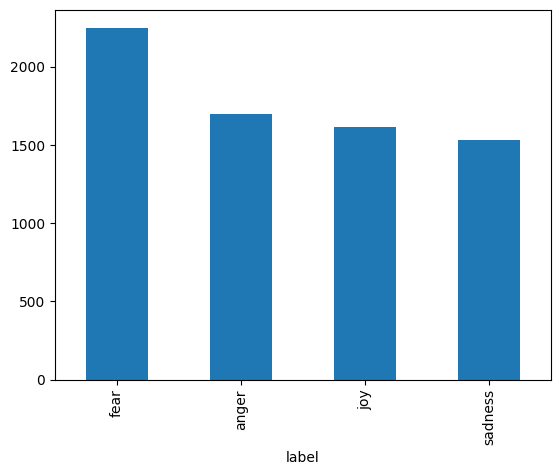

In [13]:
data['label'].value_counts().plot(kind="bar")

In [14]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [15]:
g=data.groupby('label')
data=pd.DataFrame(g.apply(lambda x:x.sample(g.size().min())).reset_index(drop=True))

<Axes: xlabel='label'>

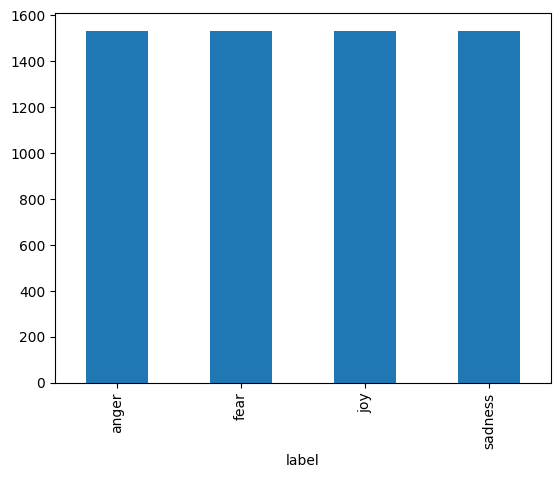

In [16]:
data['label'].value_counts().plot(kind="bar")

In [17]:
NUM_LABELS=4

In [18]:
train_split,test_split=train_test_split(data,train_size=0.8)
train_split,val_split=train_test_split(train_split,train_size=0.9)

In [19]:
print(len(train_split))
print(len(test_split))
print(len(val_split))


4414
1227
491


In [20]:
train_df=pd.DataFrame({"label":train_split.label_int.values,
                      "text":train_split.clean.values})
test_df=pd.DataFrame({"label":test_split.label_int.values,
                     "text":test_split.clean.values})

In [21]:
train_df=datasets.Dataset.from_dict(train_df)
test_df=datasets.Dataset.from_dict(test_df)

In [22]:
dataset_dict=datasets.DatasetDict({"train":train_df,"test":test_df})

In [23]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

Embeddings

In [19]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

d:\anaconda\envs\lda_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"],padding="max_length",max_length=128,truncation=True)

In [21]:
tokenized_datasets=dataset_dict.map(tokenize_function,batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [22]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [23]:
print(tokenized_datasets['train']['text'][0])

stop tracking back you fucking potato faced cunt errrr infuriating angry rooney mufc


In [24]:
print(tokenized_datasets['train']['input_ids'][0])

[101, 2644, 9651, 2067, 2017, 8239, 14557, 4320, 12731, 3372, 9413, 12171, 2099, 1999, 27942, 15370, 4854, 24246, 14163, 11329, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
tokenizer.decode(5)

'[unused4]'

In [27]:
print(tokenized_datasets['train']['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
small_train_datasets=tokenized_datasets["train"].shuffle(seed=42)
small_eval_datasets=tokenized_datasets["test"].shuffle(seed=42)

In [29]:
small_train_datasets

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 4414
})

MODEL FINE TUNNING

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                     num_labels=NUM_LABELS,
                                                     id2label={0:'anger',1:'fear',2:'joy',3:'sadness'})
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [31]:
metrics=evaluate.load("accuracy")

In [32]:
def compute_metrics(eval_pred):
    logits,labels=eval_pred
    predictions=np.argmax(logits,axis=-1)
    return metrics.compute(predictions=predictions,references=labels)

In [33]:
training_args=TrainingArguments(output_dir="test_trainer",eval_strategy="epoch",num_train_epochs=3)

In [34]:
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_datasets,
    eval_dataset=small_eval_datasets,
    compute_metrics=compute_metrics
)

In [35]:
trainer.train()

TrainOutput(global_step=1656, training_loss=0.36751128510000625, metrics={'train_runtime': 470.0579, 'train_samples_per_second': 28.171, 'train_steps_per_second': 3.523, 'total_flos': 438548964489216.0, 'train_loss': 0.36751128510000625, 'epoch': 3.0})

In [36]:
trainer.evaluate()

{'eval_loss': 0.5099444389343262,
 'eval_accuracy': 0.8753056234718827,
 'eval_runtime': 7.9483,
 'eval_samples_per_second': 154.372,
 'eval_steps_per_second': 19.375,
 'epoch': 3.0}

In [37]:
model.save_pretrained("fine_tuned_distilbert_model")

In [3]:
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained("fine_tuned_distilbert_model")

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cuda:0


In [25]:
rand_int = random.randint(0, len(val_split))
print(val_split['clean'].iloc[rand_int])
answer = clf(val_split['clean'].iloc[rand_int], top_k=None)
print(answer)

a hearty jonza to all my friends and follower
[{'label': 'joy', 'score': 0.998887836933136}, {'label': 'anger', 'score': 0.000527768163010478}, {'label': 'sadness', 'score': 0.00037935725413262844}, {'label': 'fear', 'score': 0.00020499499805737287}]


In [26]:
while True:
    user_input = input("Enter text (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    result = clf(user_input)
    print(f"{result[0]['label']}: {result[0]['score']:.4f}")

joy: 0.7417
fear: 0.3621
anger: 0.9948
fear: 0.3621
